In [35]:
#import sys, os
#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

#from src.auxiliar_functions import ejecutar_pipeline_completo
#ejecutar_pipeline_completo()

In [36]:
import pandas as pd
import os

folder = '../data/processed'
filename = 'dataset_final.csv'
file_path = os.path.join(folder, filename)

try:
    df = pd.read_csv(
        file_path,
        sep=',',
        decimal='.'
    )
    
    print(f"✅ DataFrame cargado exitosamente desde: {file_path}")
    print(f"Dimensiones: {df.shape}")
    print("\nPrimeras 5 filas:")
    print(df.head())

except FileNotFoundError:
    print(f"❌ Error: No se encontró el archivo en la ruta: {file_path}")
except Exception as e:
    print(f"❌ Error al leer el archivo: {e}")

✅ DataFrame cargado exitosamente desde: ../data/processed\dataset_final.csv
Dimensiones: (1184, 106)

Primeras 5 filas:
          DIA  Frio (Kw)  Hl de Mosto  Sala Maq (Kw)  Servicios (Kw)  \
0  2020-07-01    23954.0          0.0        17080.0         23848.0   
1  2020-07-02    28268.0       2907.0        27216.0         38033.0   
2  2020-07-03    24246.0       4829.0        31386.0         42565.5   
3  2020-07-04    29885.0       7828.0        28070.0         39650.0   
4  2020-07-05    24449.0       6406.0        33463.0         45385.0   

   KW Gral Planta  Planta (Kw)  Agua Planta (Hl)  Planta de agua (Hl)  \
0         59058.0     27637.27           10280.0             11241.40   
1        131184.0     54409.81           13970.0             22107.77   
2        136078.0     65685.59           36300.0             46955.43   
3        139714.0     67098.54           40120.0             51124.18   
4        146862.0     70600.64           38940.0             49146.08   

   KW Tr

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1184 entries, 0 to 1183
Columns: 106 entries, DIA to estacion
dtypes: float64(100), int64(3), object(3)
memory usage: 980.6+ KB


In [38]:
import pandas as pd

# --- Calcular resumen ---
resumen = df.describe().T
resumen['rango'] = resumen['max'] - resumen['min']
resumen_num = resumen[['min', 'max', 'rango']].apply(pd.to_numeric, errors='coerce')

# --- Ordenar por rango antes del formateo ---
resumen_ordenado = resumen_num.sort_values('rango', ascending=True)

# --- Función para formatear condicionalmente ---
def formato_condicional(x):
    if abs(x) >= 1e5 or (abs(x) > 0 and abs(x) < 1e-3):
        return f"{x:.3e}"  # Notación científica
    else:
        return f"{x:.3f}"  # Decimal normal

# --- Aplicar formato solo después del ordenamiento ---
resumen_formateado = resumen_ordenado.map(formato_condicional)

print(resumen_formateado)


                           min        max      rango
Anio                  2020.000   2023.000      3.000
CO 2 Filtro / Hl         0.000      6.000      6.000
Mes                      1.000     12.000     11.000
Dia                      1.000     31.000     30.000
Temperatura_amb          3.913     35.127     31.215
...                        ...        ...        ...
Resto Serv (Kw)     -8.868e+06  5.783e+05  9.447e+06
KW Gral Planta       40506.000  9.655e+06  9.615e+06
Tarifa_electrica     8.759e+07  1.407e+10  1.398e+10
Envasado (Kw)          347.000  3.277e+16  3.277e+16
Restos Planta (Kw)  -3.277e+16  4.738e+06  3.277e+16

[103 rows x 3 columns]


In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 

# EDA
Vamos a comenzar analizando nuestra variable objetivo Frio(Kw).  El dataset presenta muchos outliers, para comprender mejor los patrones vamos a hacer los analisis sobre una dataset sin outliers, pero solo para comprender como se distribuyen mejor los datos.

In [40]:
def limpiar_outliers_iqr(df, columnas_a_limpiar, k=1.5):
    df_limpio = df.copy()
    
    print("Iniciando limpieza de outliers...")
    
    for columna in columnas_a_limpiar:
        if columna not in df_limpio.columns:
            continue
            
        if not pd.api.types.is_numeric_dtype(df_limpio[columna]):
            continue

        
        Q1 = df_limpio[columna].quantile(0.05)
        Q3 = df_limpio[columna].quantile(0.95)
        IQR = Q3 - Q1
        
        limite_inferior = Q1 - (k * IQR)
        limite_superior = Q3 + (k * IQR)
        
        outliers_antes = df_limpio[
            (df_limpio[columna] < limite_inferior) | 
            (df_limpio[columna] > limite_superior)
        ].shape[0]
        
        if outliers_antes > 0:
            
            df_limpio.loc[
                (df_limpio[columna] < limite_inferior) | 
                (df_limpio[columna] > limite_superior), 
                columna
            ] = np.nan


    print("Limpieza completada.")
    return df_limpio

columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
df_limpio = limpiar_outliers_iqr(df, columnas_numericas)

Iniciando limpieza de outliers...


Limpieza completada.


## Analisis univariado
- Analisis variable target
- Analisis variable hl_mosto
- Analisis variable Planta (Kw)
- Analisis variables categoricas (dia_semana, estación)

In [41]:
df.columns

Index(['DIA', 'Frio (Kw)', 'Hl de Mosto', 'Sala Maq (Kw)', 'Servicios (Kw)',
       'KW Gral Planta', 'Planta (Kw)', 'Agua Planta (Hl)',
       'Planta de agua (Hl)', 'KW Trafo 10',
       ...
       'Totalizador_Bodega', 'Agua Calderas', 'Hl Cerveza L4', 'Anio', 'Mes',
       'Dia', 'Dia_semana', 'Temperatura_amb', 'Tarifa_electrica', 'estacion'],
      dtype='object', length=106)

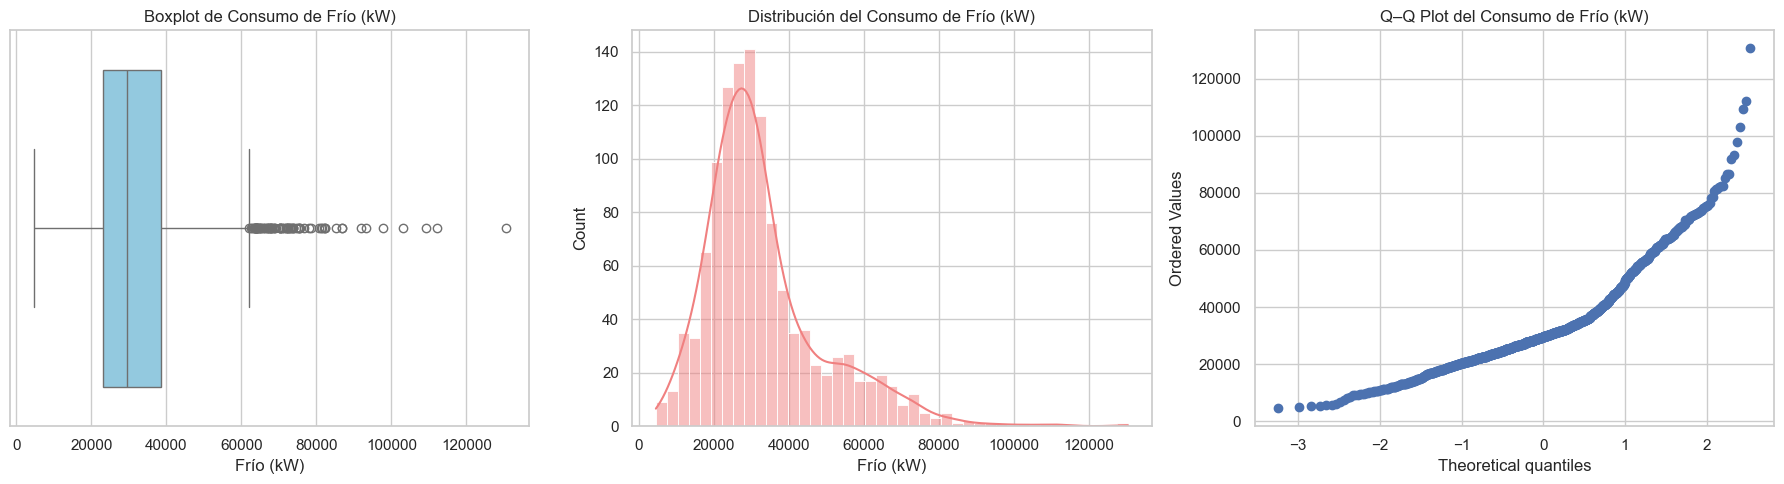

In [42]:
# Configuración de estilo
sns.set(style="whitegrid", palette="deep")

# Crear figura con tres subplots horizontales
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Boxplot ---
sns.boxplot(data=df_limpio, x="Frio (Kw)", ax=axs[0], color="skyblue")
axs[0].set_title("Boxplot de Consumo de Frío (kW)")
axs[0].set_xlabel("Frío (kW)")

# --- 2. Distribución (histograma + KDE) ---
sns.histplot(data=df_limpio, x="Frio (Kw)", kde=True, ax=axs[1], color="lightcoral")
axs[1].set_title("Distribución del Consumo de Frío (kW)")
axs[1].set_xlabel("Frío (kW)")

# --- 3. Q-Q Plot ---
stats.probplot(df_limpio["Frio (Kw)"], dist="norm", plot=axs[2])
axs[2].set_title("Q–Q Plot del Consumo de Frío (kW)")

# Ajustar espacios
plt.tight_layout()
plt.show()


Podemos apreciar que el target se distribuye aproximadamente de manera normal y que los valores de la variable se agrupan entre 20000- 40000 Kw de consumo de Frio.

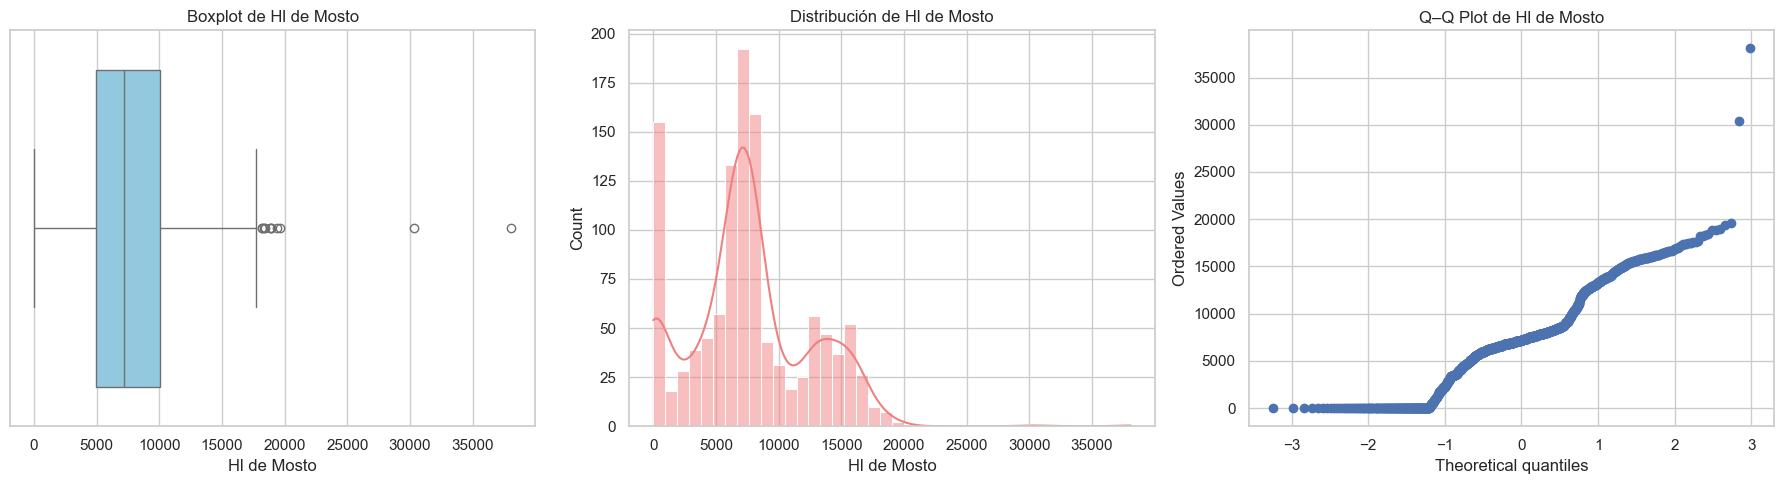

In [43]:
# Crear figura con tres subplots horizontales
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Boxplot ---
sns.boxplot(data=df_limpio, x="Hl de Mosto", ax=axs[0], color="skyblue")
axs[0].set_title("Boxplot de Hl de Mosto")
axs[0].set_xlabel("Hl de Mosto")

# --- 2. Distribución (histograma + KDE) ---
sns.histplot(data=df_limpio, x="Hl de Mosto", kde=True, ax=axs[1], color="lightcoral")
axs[1].set_title("Distribución de Hl de Mosto")
axs[1].set_xlabel("Hl de Mosto")

# --- 3. Q–Q Plot ---
stats.probplot(df_limpio["Hl de Mosto"], dist="norm", plot=axs[2])
axs[2].set_title("Q–Q Plot de Hl de Mosto")

# Ajustar espacios
plt.tight_layout()
plt.show()

vemos que hay muchas variables de produccion 0 de mosto, consideramos esto como una forma de no poner información sobre lo que se produjo en el dia o lo qu ees equivalente, un NaN. Mas adelante recurriremos a ellas como una forma de imputación

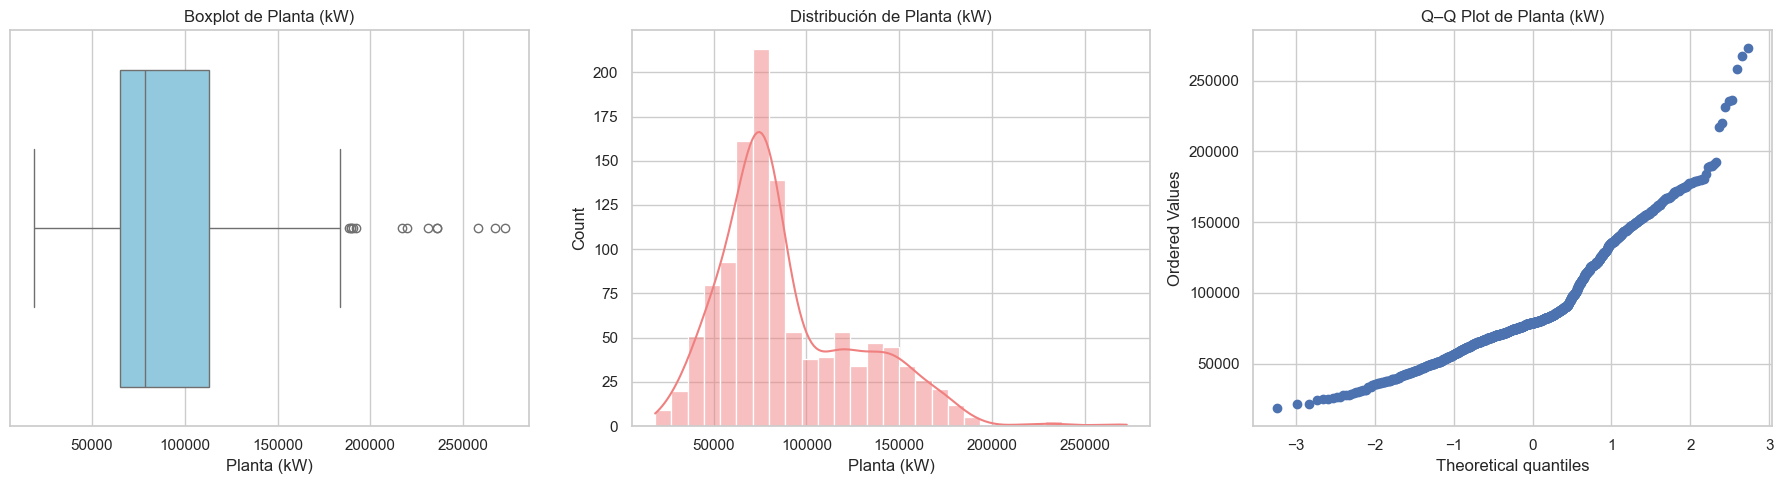

In [44]:
# Crear figura con tres subplots horizontales
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Boxplot ---
sns.boxplot(data=df_limpio, x="Planta (Kw)", ax=axs[0], color="skyblue")
axs[0].set_title("Boxplot de Planta (kW)")
axs[0].set_xlabel("Planta (kW)")

# --- 2. Distribución (histograma + KDE) ---
sns.histplot(data=df_limpio, x="Planta (Kw)", kde=True, ax=axs[1], color="lightcoral")
axs[1].set_title("Distribución de Planta (kW)")
axs[1].set_xlabel("Planta (kW)")

# --- 3. Q–Q Plot ---
stats.probplot(df_limpio["Planta (Kw)"], dist="norm", plot=axs[2])
axs[2].set_title("Q–Q Plot de Planta (kW)")

# Ajustar espacios
plt.tight_layout()
plt.show()

Podemos ver que el consumo de la planta y el consumo del frio tienen tendencias similares (distribuciones parecidas en su morfologia). Esto deberia ser respaldado por un coeficiente de Spearman elevado.

Mientras tanto para las variables categoricas.

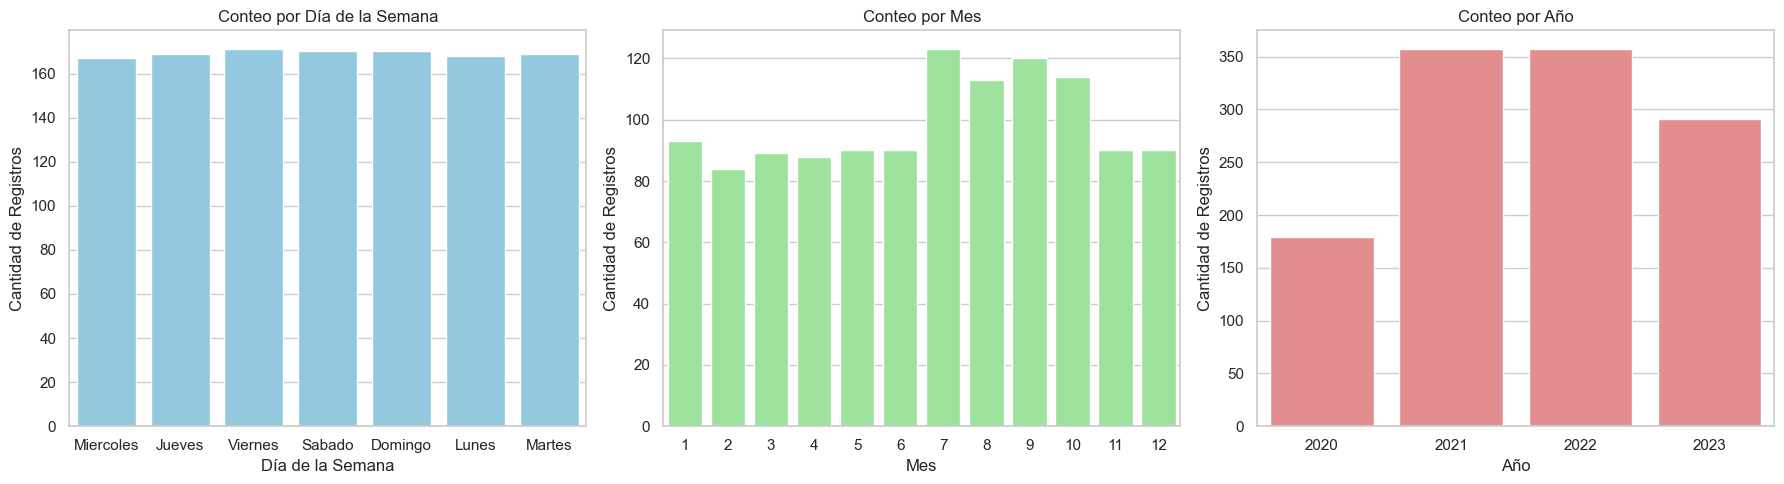

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# --- 1. Conteo por Día de la semana ---
sns.countplot(data=df_limpio, x="Dia_semana", ax=axs[0], color="skyblue")
axs[0].set_title("Conteo por Día de la Semana")
axs[0].set_xlabel("Día de la Semana")
axs[0].set_ylabel("Cantidad de Registros")

# --- 2. Conteo por Mes ---
sns.countplot(data=df_limpio, x="Mes", ax=axs[1], color="lightgreen")
axs[1].set_title("Conteo por Mes")
axs[1].set_xlabel("Mes")
axs[1].set_ylabel("Cantidad de Registros")

# --- 3. Conteo por Año ---
sns.countplot(data=df_limpio, x="Anio", ax=axs[2], color="lightcoral")
axs[2].set_title("Conteo por Año")
axs[2].set_xlabel("Año")
axs[2].set_ylabel("Cantidad de Registros")

# Ajustar el diseño
plt.tight_layout()
plt.show()

Mas o menos equilibrado los dias de la semana, los meses difieren un poco y los años falta mucha informacion respecto a 2020 porque se cominezan los datos desde julio. 

Lo ideal y lo que debieramos tener son la misma cantidad de observaciones en todo.

## Analisis bivariado y multivariado
Vamos a analizar:
- Analisis temporal y estacionario:
    - Consumo de Frio (Kw)
    - Produccion (Kw)
    - PLanta (Kw)
    - Hl de Mosto
- Analisis entre variables
- Analisis de correlacion:
    - entre todas
    - Respecto al Target.

### analisis temporal

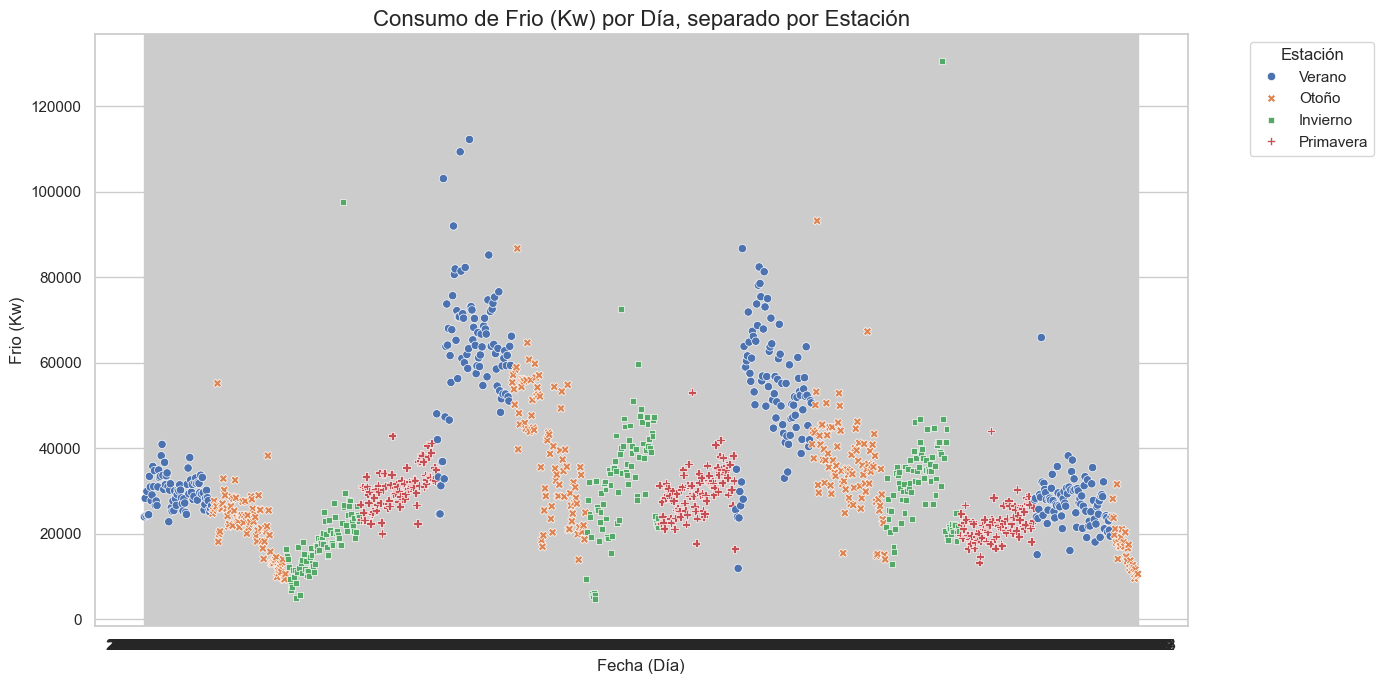

In [46]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))

sns.scatterplot(
    data=df_limpio,
    x='DIA',
    y='Frio (Kw)',
    hue='estacion',
    style='estacion',  
    markers=True,      
)

plt.title('Consumo de Frio (Kw) por Día, separado por Estación', fontsize=16)
plt.xlabel('Fecha (Día)', fontsize=12)
plt.ylabel('Frio (Kw)', fontsize=12)

plt.legend(title='Estación', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Podemos ver que se nota una especie de patron periodico respecto a las estaciones, por ejemplo:
- crecimiento constante en invierno, primavera y verano
- decrecimiento en otoño

Podemos analizar el rango de valores cuales oscilan las estaciones

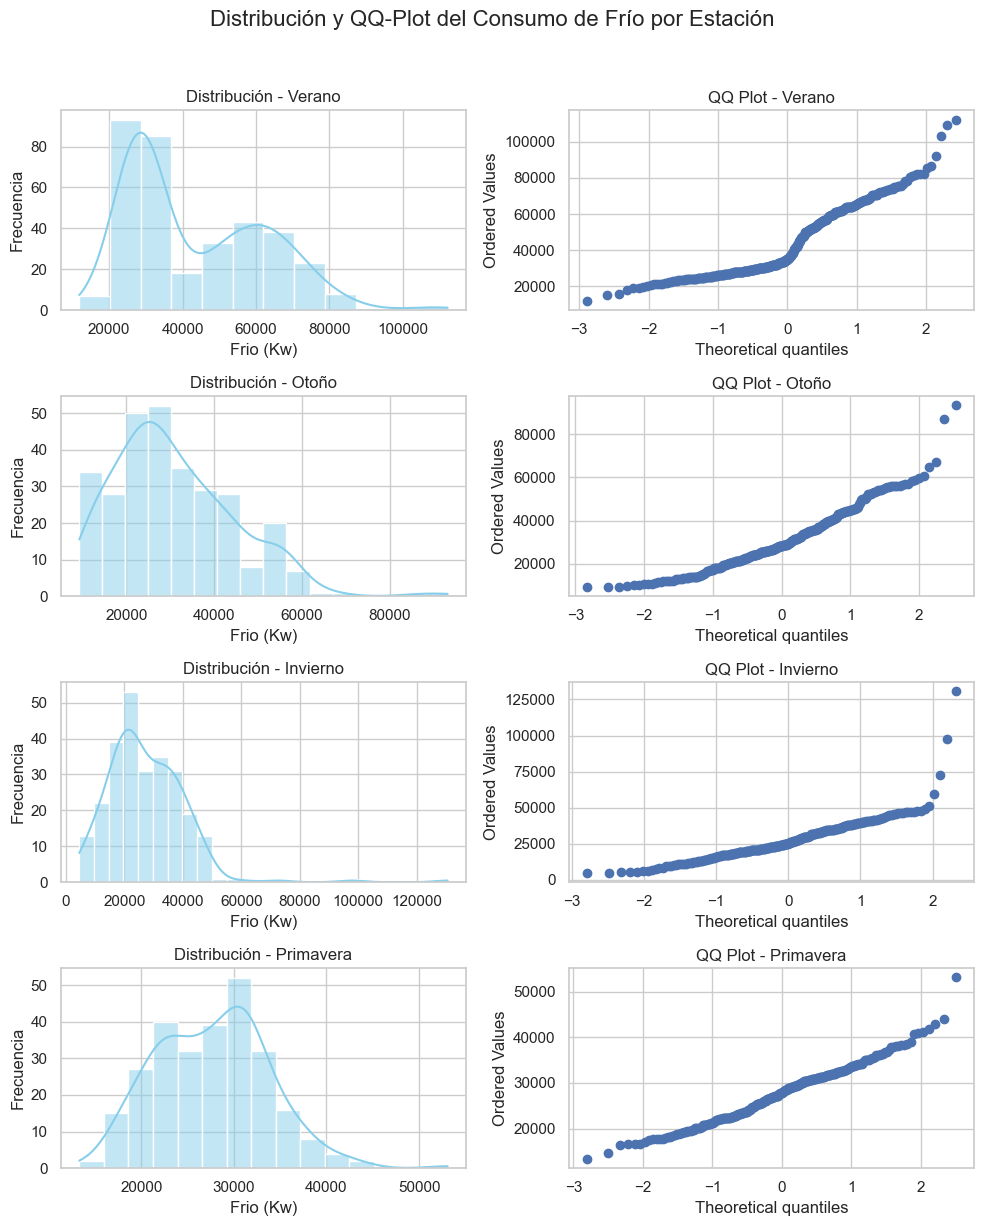

In [47]:
import scipy.stats as stats
sns.set(style="whitegrid")
estaciones = df_limpio["estacion"].unique()

fig, axes = plt.subplots(nrows=len(estaciones), ncols=2, figsize=(10, 12))
fig.suptitle("Distribución y QQ-Plot del Consumo de Frío por Estación", fontsize=16, y=1.02)

for i, estacion in enumerate(estaciones):
    datos = df_limpio[df_limpio["estacion"] == estacion]["Frio (Kw)"]
    
    # --- Gráfico de distribución ---
    sns.histplot(datos, kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f"Distribución - {estacion}")
    axes[i, 0].set_xlabel("Frio (Kw)")
    axes[i, 0].set_ylabel("Frecuencia")

    # --- QQ Plot ---
    stats.probplot(datos, dist="norm", plot=axes[i, 1])
    axes[i, 1].set_title(f"QQ Plot - {estacion}")

plt.tight_layout()
plt.show()

Las distribuciones son aproximadamente normales a excepcion del verano que presenta como dos clusters de valores posibles.
- Se consume mas en verano y otoño que en invierno y primavera.

Podemos ver el consumo promedio que se tiene por meses

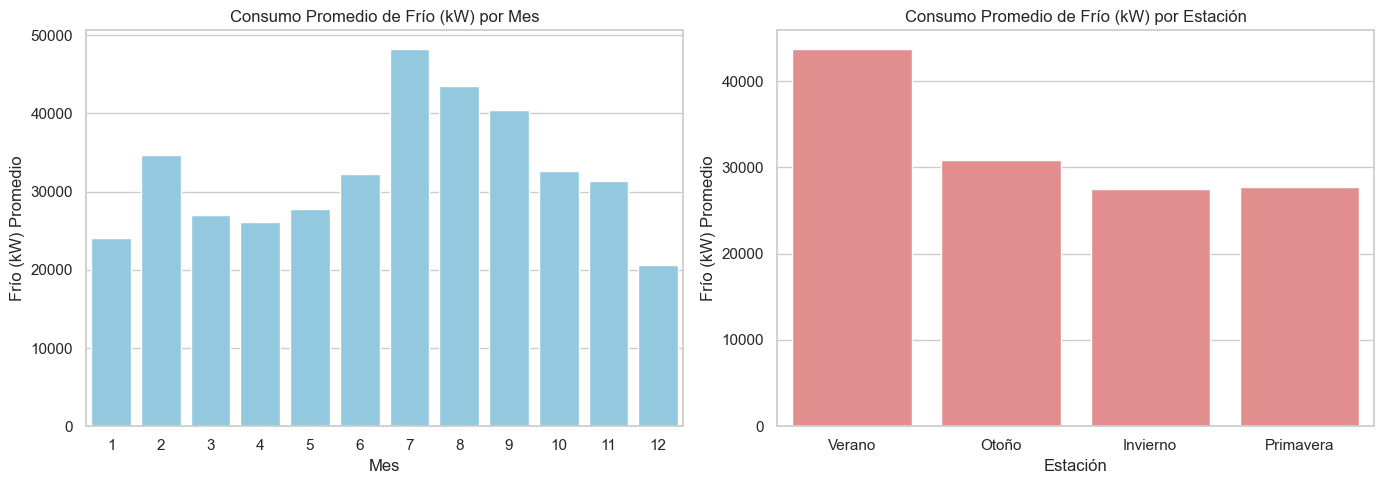

C:\Users\MATEOCRACK\AppData\Local\Temp\ipykernel_17008\340184867.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_limpio, x="Mes", y="Frio (Kw)", palette="coolwarm")


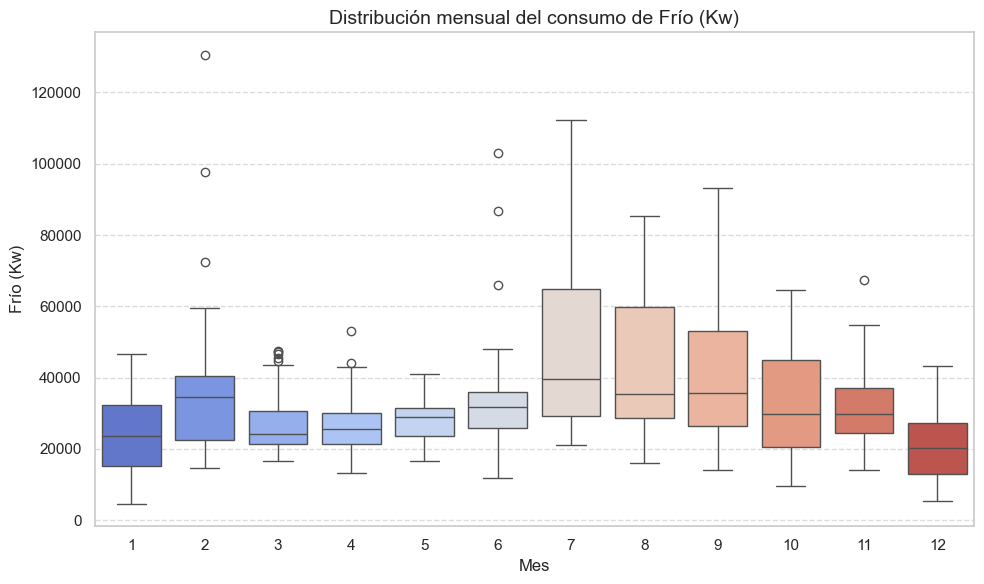

In [52]:
sns.set(style="whitegrid", palette="deep")

# Crear figura con dos subplots horizontales
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# --- 1. Promedio de Frío (kW) por Mes ---
sns.barplot(
    data=df_limpio,
    x="Mes",
    y="Frio (Kw)",
    estimator="mean",
    errorbar =None,
    ax=axs[0],
    color="skyblue"
)
axs[0].set_title("Consumo Promedio de Frío (kW) por Mes")
axs[0].set_xlabel("Mes")
axs[0].set_ylabel("Frío (kW) Promedio")

# --- 2. Promedio de Frío (kW) por Estación ---
sns.barplot(
    data=df_limpio,
    x="estacion",
    y="Frio (Kw)",
    estimator="mean",
    errorbar=None,
    ax=axs[1],
    color="lightcoral"
)
axs[1].set_title("Consumo Promedio de Frío (kW) por Estación")
axs[1].set_xlabel("Estación")
axs[1].set_ylabel("Frío (kW) Promedio")

# Ajustar el diseño
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_limpio, x="Mes", y="Frio (Kw)", palette="coolwarm")

plt.title("Distribución mensual del consumo de Frío (Kw)", fontsize=14)
plt.xlabel("Mes")
plt.ylabel("Frío (Kw)")
plt.xticks(range(0, 12), range(1, 13))  # asegurar que aparezcan todos los meses
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Logicamente los meses donde mas consumo de frio se necesita (probablemente en respuesta a la produccion) son los meses de verano y los meses de menor produccion (incluso por temperatura ambiente) es en invierno.

Por el lado del boxplot, podemos ver tambien que el consumo de frio es mas variado en estos meses de mayor consumo, ademas de tener una mayor media. Es una clara evidencia de estacionariedad.

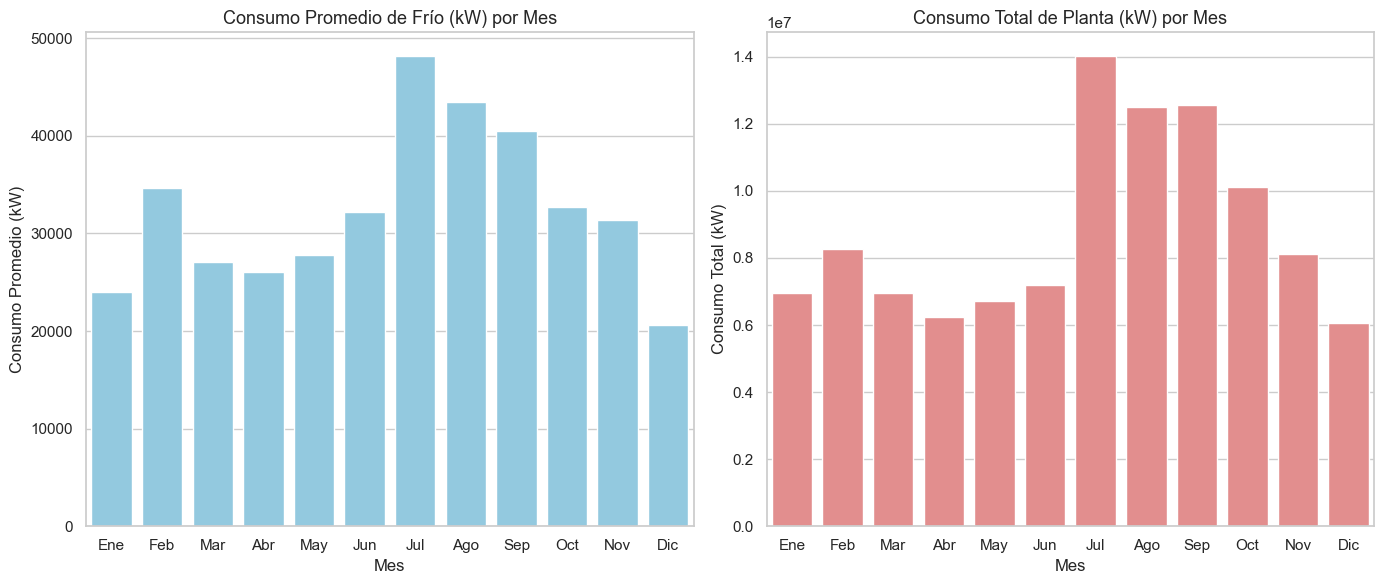

In [49]:
sns.set(style="whitegrid", palette="deep")

# --- Calcular consumo promedio mensual de frío ---
consumo_mensual = (
    df_limpio.groupby("Mes")["Frio (Kw)"]
    .mean()
    .reset_index()
    .sort_values("Mes")
)

# --- Calcular consumo total mensual de Planta ---
planta_mensual = (
    df_limpio.groupby("Mes")["Planta (Kw)"]
    .sum()
    .reset_index()
    .sort_values("Mes")
)

# --- Crear figura con dos gráficos ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# === Gráfico 1: Consumo Promedio de Frío ===
sns.barplot(data=consumo_mensual, x="Mes", y="Frio (Kw)", color="skyblue", ax=axes[0])
axes[0].set_title("Consumo Promedio de Frío (kW) por Mes", fontsize=13)
axes[0].set_xlabel("Mes")
axes[0].set_ylabel("Consumo Promedio (kW)")
axes[0].set_xticks(range(0, 12))
axes[0].set_xticklabels(
    ["Ene", "Feb", "Mar", "Abr", "May", "Jun",
     "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]
)

# === Gráfico 2: Consumo Total de Planta ===
sns.barplot(data=planta_mensual, x="Mes", y="Planta (Kw)", color="lightcoral", ax=axes[1])
axes[1].set_title("Consumo Total de Planta (kW) por Mes", fontsize=13)
axes[1].set_xlabel("Mes")
axes[1].set_ylabel("Consumo Total (kW)")
axes[1].set_xticks(range(0, 12))
axes[1].set_xticklabels(
    ["Ene", "Feb", "Mar", "Abr", "May", "Jun",
     "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]
)

plt.tight_layout()
plt.show()

Podemos observar que otras vartiables como el consumo total de la planta se comporta distribuye de manera similar respecto al consumo promedio de Frio. Esto implica que quizas sean variables muy correlacionadas.

Por otra parte podemos analizar temporalmente y hacer un analisis reducido similar con otras variables, como por ejemplo:
- Frio (Kw) 
- Planta (Kw) 
- Produccion (Hl) 
- Hl de Mosto

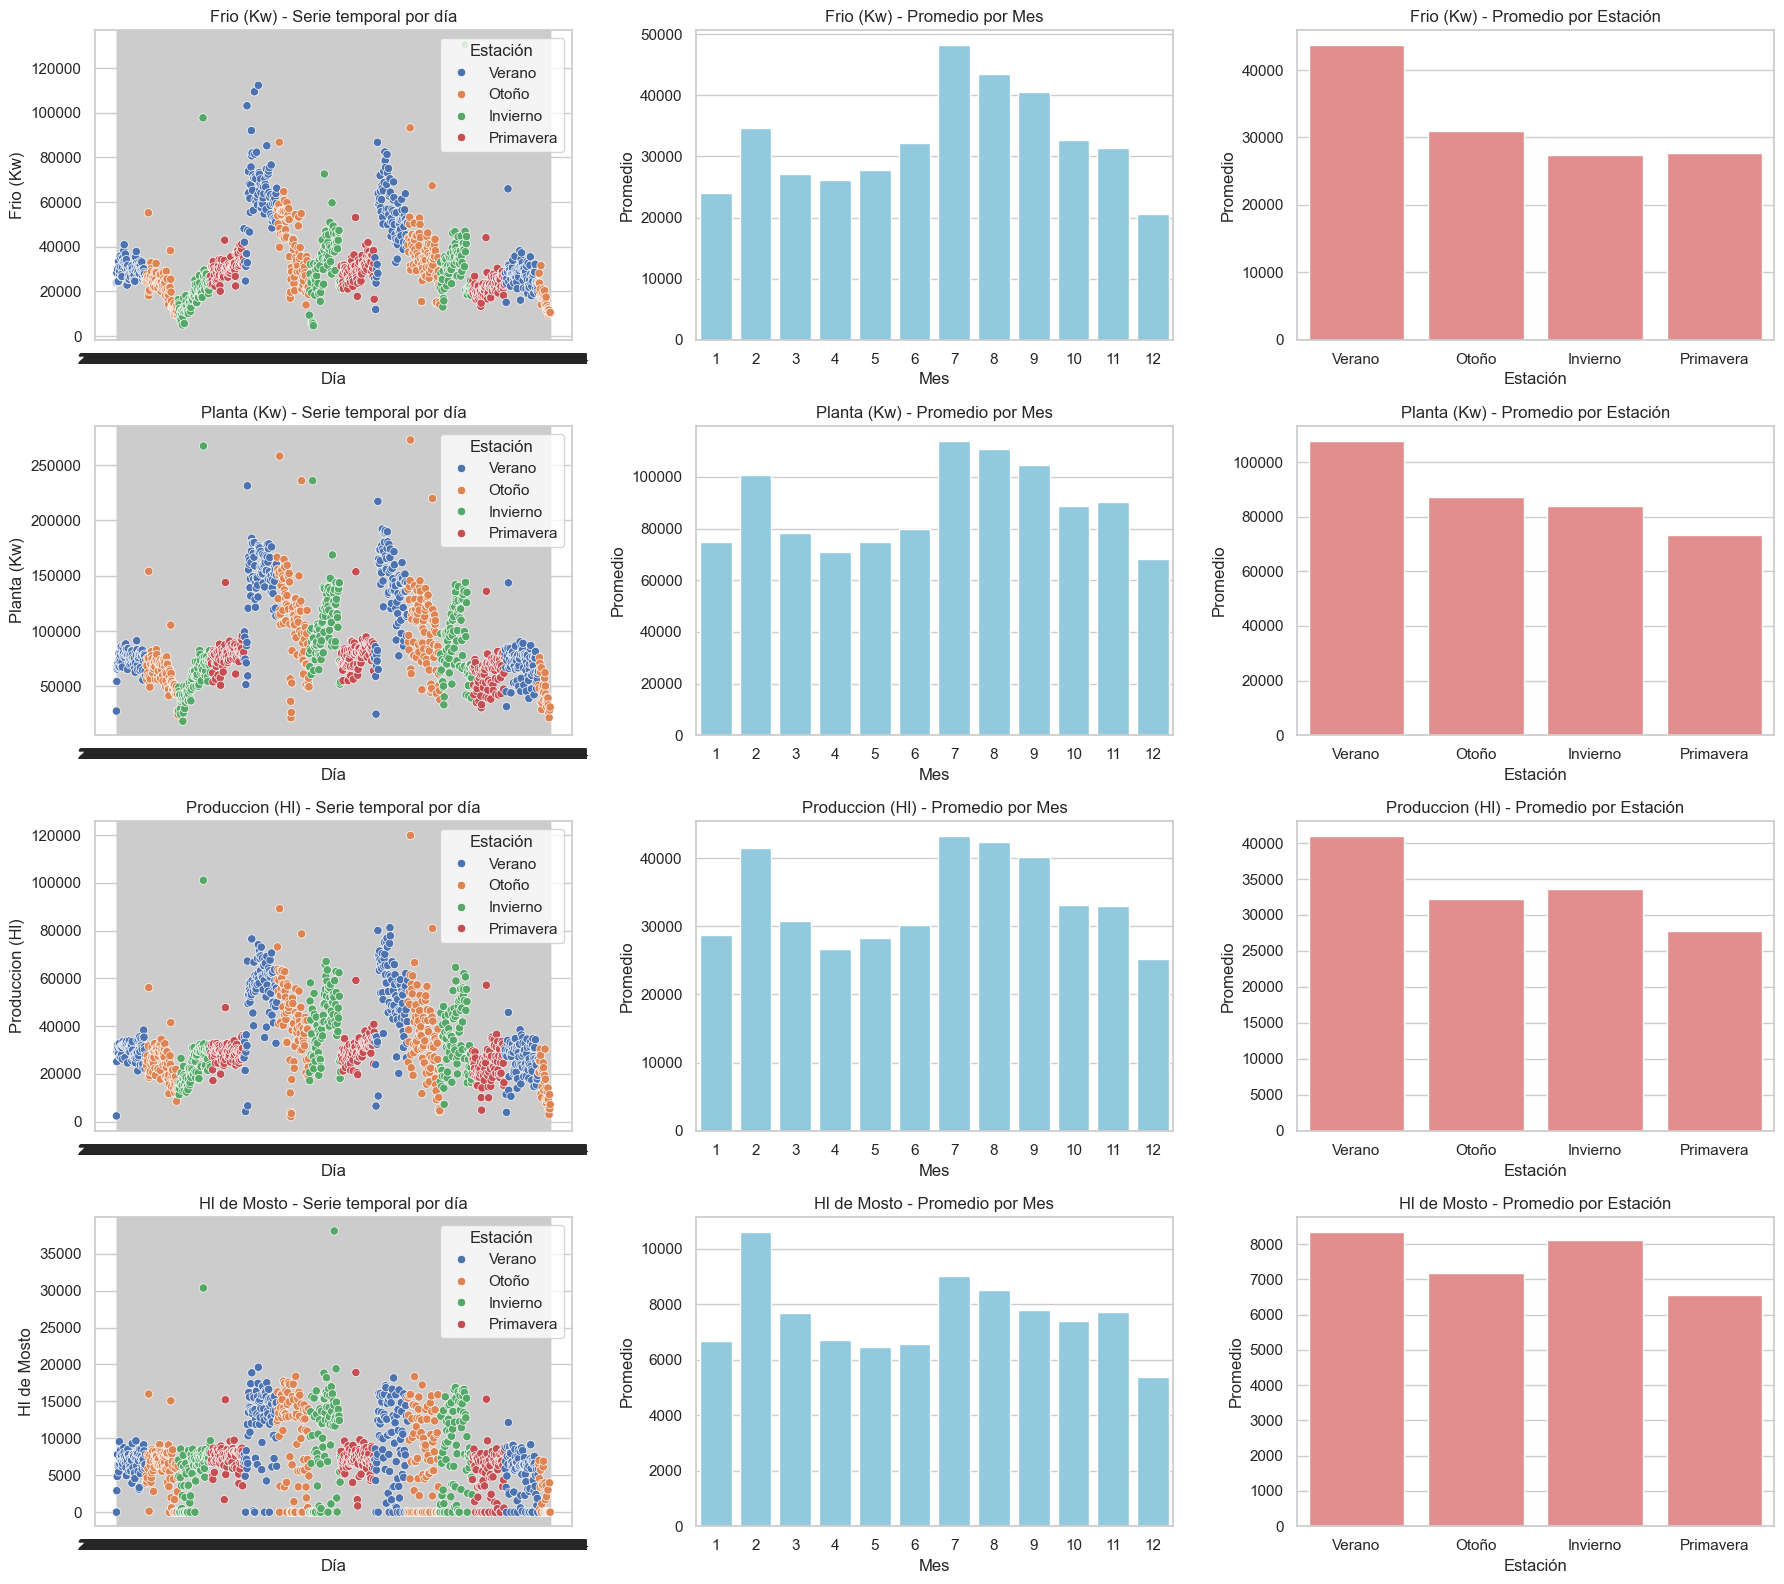

In [50]:
sns.set(style="whitegrid", palette="deep")

# Lista de variables a analizar
variables = ["Frio (Kw)", "Planta (Kw)", "Produccion (Hl)", "Hl de Mosto"]

# Crear figura con 4 filas × 3 columnas
fig, axs = plt.subplots(len(variables), 3, figsize=(18, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Iterar sobre cada variable
for i, var in enumerate(variables):

    # --- 1. Serie temporal por día con hue estación ---
    sns.scatterplot(data=df_limpio, x="DIA", y=var, hue="estacion", ax=axs[i, 0])
    axs[i, 0].set_title(f"{var} - Serie temporal por día")
    axs[i, 0].set_xlabel("Día")
    axs[i, 0].set_ylabel(var)

    # --- 2. Promedio por Mes ---
    sns.barplot(
        data=df_limpio,
        x="Mes",
        y=var,
        estimator="mean",
        errorbar=None,
        ax=axs[i, 1],
        color="skyblue"
    )
    axs[i, 1].set_title(f"{var} - Promedio por Mes")
    axs[i, 1].set_xlabel("Mes")
    axs[i, 1].set_ylabel("Promedio")

    # --- 3. Promedio por Estación ---
    sns.barplot(
        data=df_limpio,
        x="estacion",
        y=var,
        estimator="mean",
        errorbar=None,
        ax=axs[i, 2],
        color="lightcoral"
    )
    axs[i, 2].set_title(f"{var} - Promedio por Estación")
    axs[i, 2].set_xlabel("Estación")
    axs[i, 2].set_ylabel("Promedio")

# Ajustar leyenda de la primera columna (evitar repeticiones)
for ax in axs[:, 0]:
    ax.legend(title="Estación", loc="upper right")

plt.tight_layout()
plt.show()

Los patrones se ven muy similares, lo que difiere mucho las tendencias es la produccion de mosto donde pareciera ser mas ruidosa. Quizas si los valores nulos sean rellenados, se pueden entender mejor el comportamiento.
Por otro lado, esta variable Hl de MOsto pareciera ser mas constante por estación

### Analisis Cruzado
Podemos analizar como evoluciona el consumo de Frío en función del Consumo energetico y ver la tendencia que se tiene por estación.
Se ve que a mayor consumo energetico en Verano y Primavera requiere mas consumo de Frio que en invierno qué es lógico.

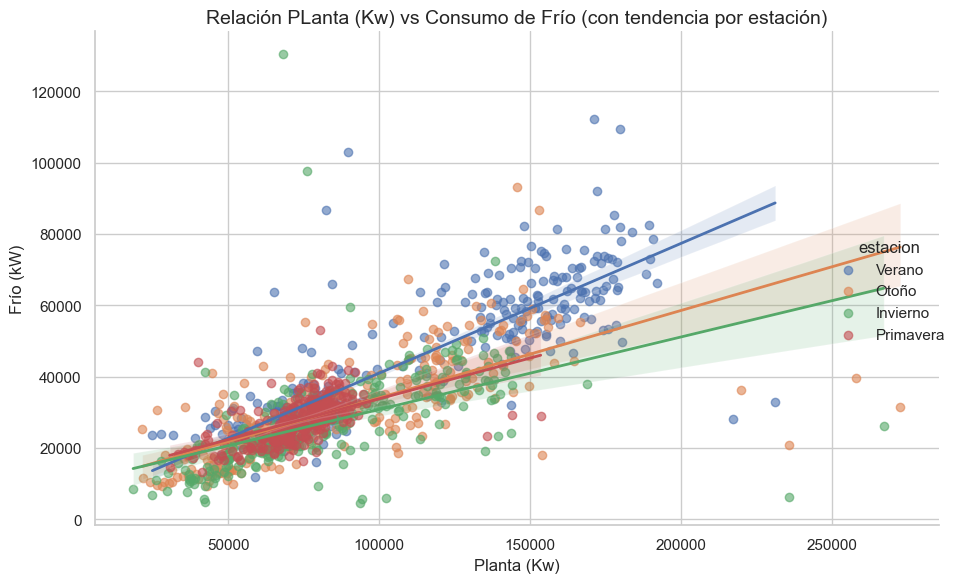

In [ ]:
sns.set(style="whitegrid")

sns.lmplot(
    data=df_limpio,
    x="Planta (Kw)",
    y="Frio (Kw)",
    hue="estacion",
    height=6,
    aspect=1.4,
    scatter_kws={"alpha": 0.6},  
    line_kws={"lw": 2},          
)

plt.title("Relación PLanta (Kw) vs Consumo de Frío (con tendencia por estación)", fontsize=14)
plt.xlabel("Planta (Kw)")
plt.ylabel("Frío (kW)")
plt.tight_layout()
plt.show()


De un analisis similar, podemos hacer lo mismo con los Hl de mosto y también con la Produccion (kw) de agua.
A pesar del ruido intrinseco en torno a la variable Hl_mosto, los patrones y tendencias siguen siendo similares.

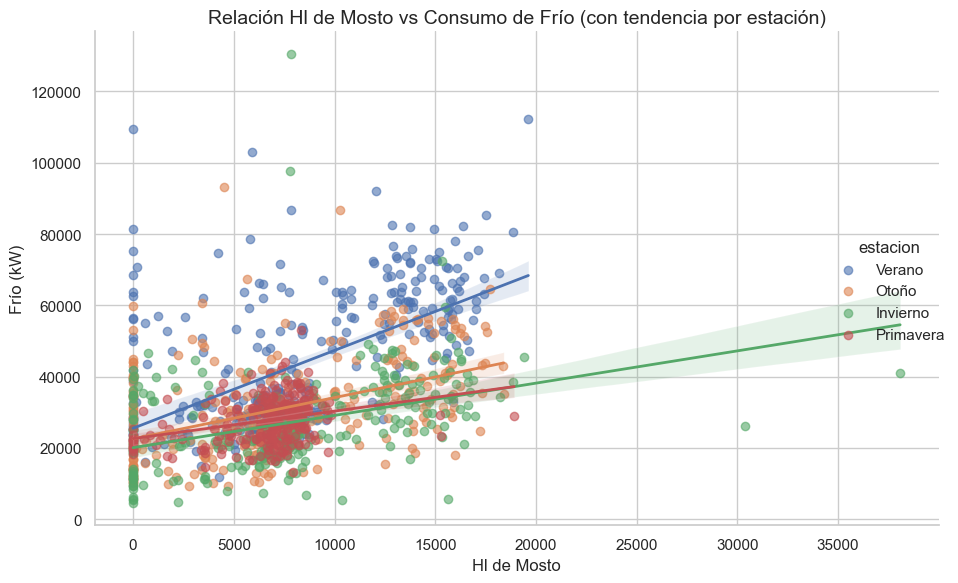

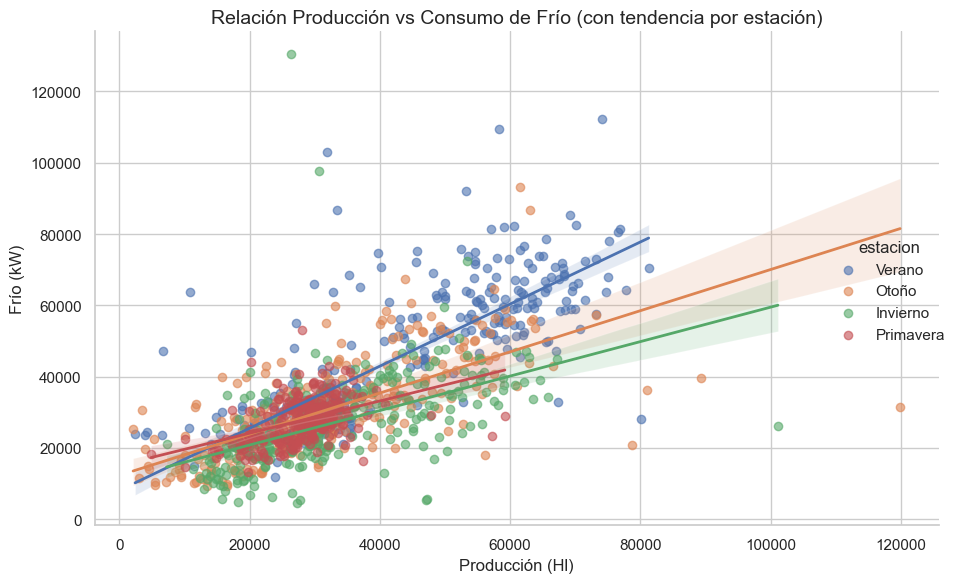

In [ ]:

sns.lmplot(
    data=df_limpio,
    x="Hl de Mosto",
    y="Frio (Kw)",
    hue="estacion",
    height=6,
    aspect=1.4,
    scatter_kws={"alpha": 0.6},  
    line_kws={"lw": 2},          
)

plt.title("Relación Hl de Mosto vs Consumo de Frío (con tendencia por estación)", fontsize=14)
plt.xlabel("Hl de Mosto")
plt.ylabel("Frío (kW)")
plt.tight_layout()
plt.show()



sns.lmplot(
    data=df_limpio,
    x="Produccion (Hl)",
    y="Frio (Kw)",
    hue="estacion",
    height=6,
    aspect=1.4,
    scatter_kws={"alpha": 0.6},  # transparencia en los puntos
    line_kws={"lw": 2},          # grosor de las líneas
)

plt.title("Relación Producción vs Consumo de Frío (con tendencia por estación)", fontsize=14)
plt.xlabel("Producción (Hl)")
plt.ylabel("Frío (kW)")
plt.tight_layout()
plt.show()



# analisis de correlacíon

In [ ]:
df.select_dtypes(include=["number"]).columns

Index(['Frio (Kw)', 'Hl de Mosto', 'Sala Maq (Kw)', 'Servicios (Kw)',
       'KW Gral Planta', 'Planta (Kw)', 'Agua Planta (Hl)',
       'Planta de agua (Hl)', 'KW Trafo 10', 'Produccion (Hl)',
       ...
       'EE Frio / Hl', 'FC CIP Bodega', 'Totalizador_Bodega', 'Agua Calderas',
       'Hl Cerveza L4', 'Anio', 'Mes', 'Dia', 'Temperatura_amb',
       'Tarifa_electrica'],
      dtype='object', length=103)

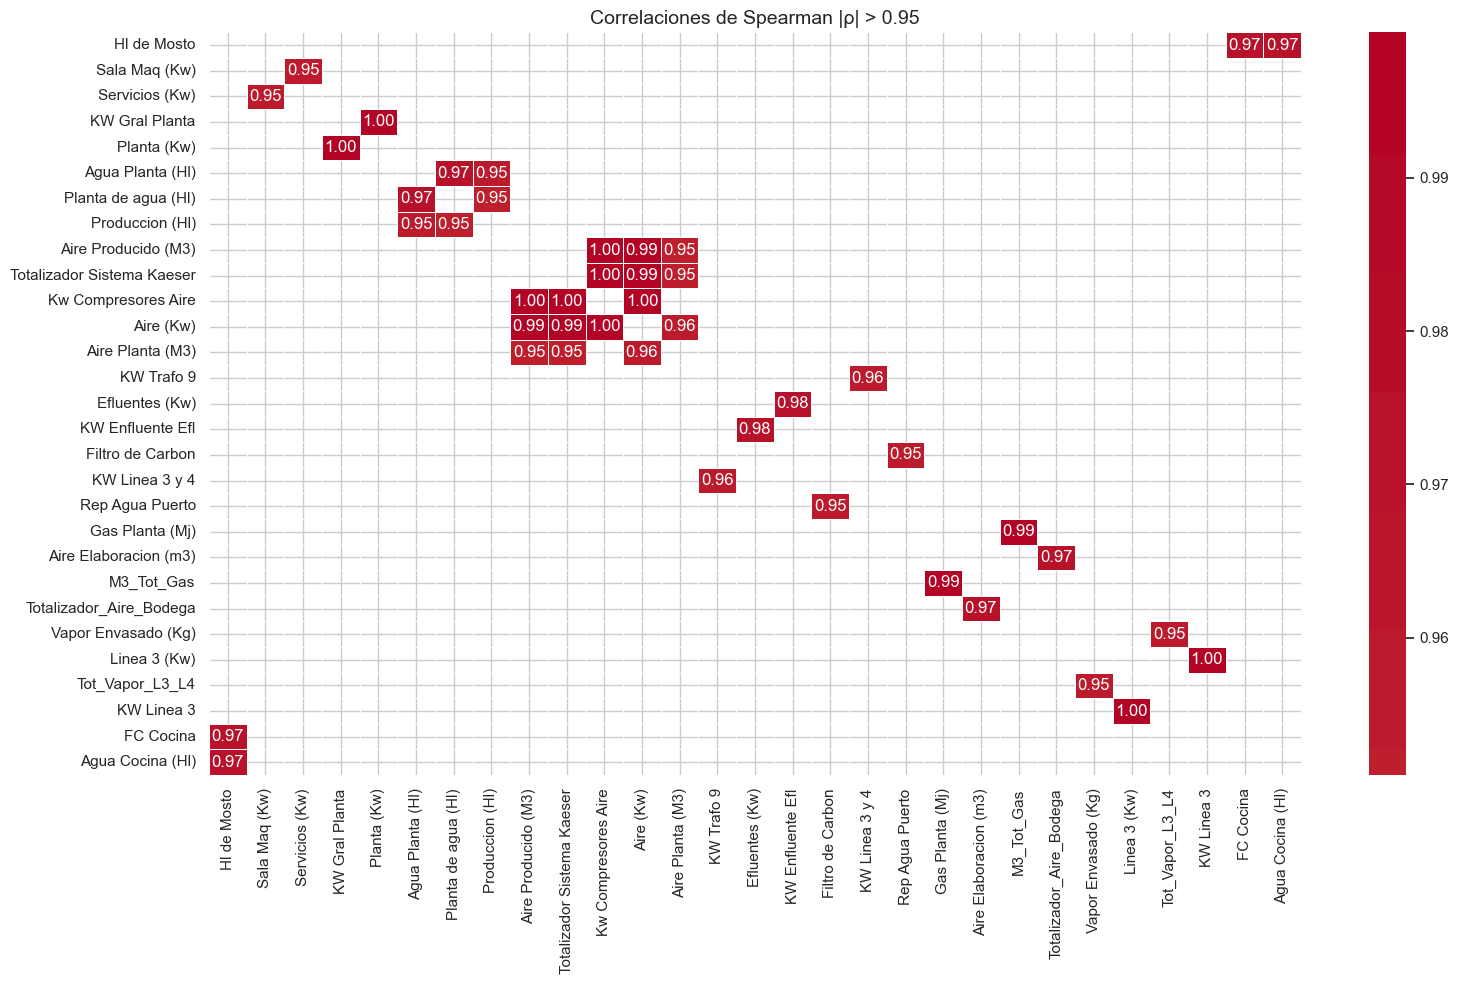

In [ ]:
# --- 0️⃣ Filtrar solo columnas numéricas ---
df_num = df.select_dtypes(include=["number"])

# --- 1️⃣ Calcular correlación de Spearman ---
corr = df_num.corr(method="spearman")
# --- 2️⃣ Filtrar correlaciones fuertes ---
strong_corr = corr[(corr.abs() > 0.95) & (corr.abs() < 1.0)]

# --- 3️⃣ Eliminar filas/columnas sin correlaciones fuertes ---
strong_corr = strong_corr.dropna(how="all", axis=0).dropna(how="all", axis=1)

# --- 4️⃣ Graficar si existen correlaciones ---
if not strong_corr.empty:
    plt.figure(figsize=(16, 10))
    sns.heatmap(
        strong_corr,
        annot=True,
        cmap="coolwarm",
        center=0,
        fmt=".2f",
        linewidths=0.5
    )
    plt.title("Correlaciones de Spearman |ρ| > 0.95", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No se encontraron correlaciones de Spearman con |ρ| > 0.95")



Podemos identificar que hay varias variables correlacionadas. Esto quiere decir que esperamos que el modelo simplifique el comportamiento de estas debido a la multicolinealidad.
Si filtramos las variables con una mayor correlación respecto al target obtenemos el siguiente resutlado.

🔝 Top 15 variables más correlacionadas con el target:
Sala Maq (Kw)                 0.829147
Servicios (Kw)                0.825287
KW Gral Planta                0.798455
Planta (Kw)                   0.797649
Agua Planta (Hl)              0.754109
Tarifa_electrica              0.751552
Planta de agua (Hl)           0.749766
KW Trafo 10                   0.730659
Produccion (Hl)               0.726973
Totalizador Sistema Kaeser    0.723714
Aire Producido (M3)           0.723714
Kw Compresores Aire           0.723647
Aire (Kw)                     0.713423
Elaboracion (Kw)              0.703196
Aire Planta (M3)              0.674695
Name: Frio (Kw), dtype: float64


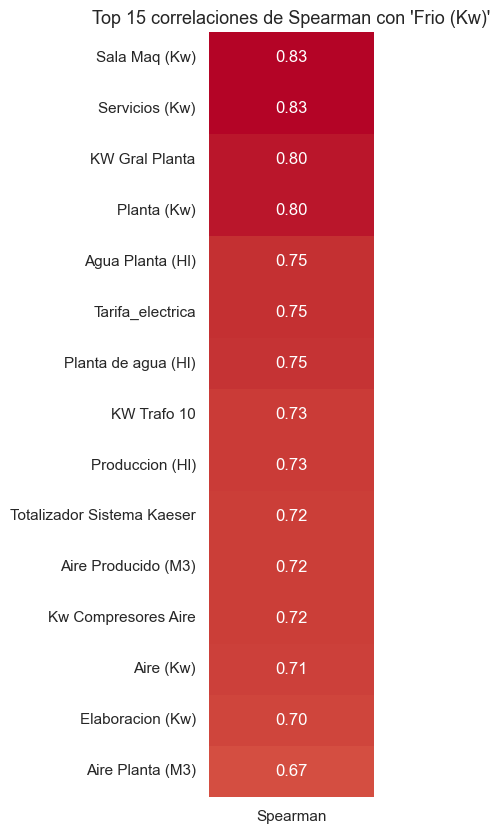

In [ ]:
target = "Frio (Kw)" 

# --- 1️⃣ Calcular correlaciones ---
corr_spearman = df.corr(method="spearman", numeric_only=True)
corr_target = corr_spearman[target].drop(target).sort_values(ascending=False)

# 🔹 Seleccionar las 15 más correlacionadas (en valor absoluto)
top15 = corr_target.abs().sort_values(ascending=False).head(15)
top15 = corr_target.loc[top15.index]  # mantener signo original

print("🔝 Top 15 variables más correlacionadas con el target:")
print(top15)

# --- 2️⃣ Mostrar en heatmap ---
plt.figure(figsize=(4, len(top15)*0.5 + 1))
sns.heatmap(
    top15.to_frame(name="Spearman"),
    annot=True,
    cmap="coolwarm",
    center=0,
    cbar=False,
    fmt=".2f"
)
plt.title(f"Top 15 correlaciones de Spearman con '{target}'", fontsize=13)
plt.tight_layout()
plt.show()

Esperaremos que estas variables en nuestro modelo sean las "Dominantes". Tal como vimos anteriormente, Planta (Kw) y Produccion (Hl) son variables donde notamos el patron similar con la evolución temporal del frio.

🔝 Top 5 variables seleccionadas: ['Sala Maq (Kw)', 'Servicios (Kw)', 'KW Gral Planta', 'Planta (Kw)', 'Agua Planta (Hl)']


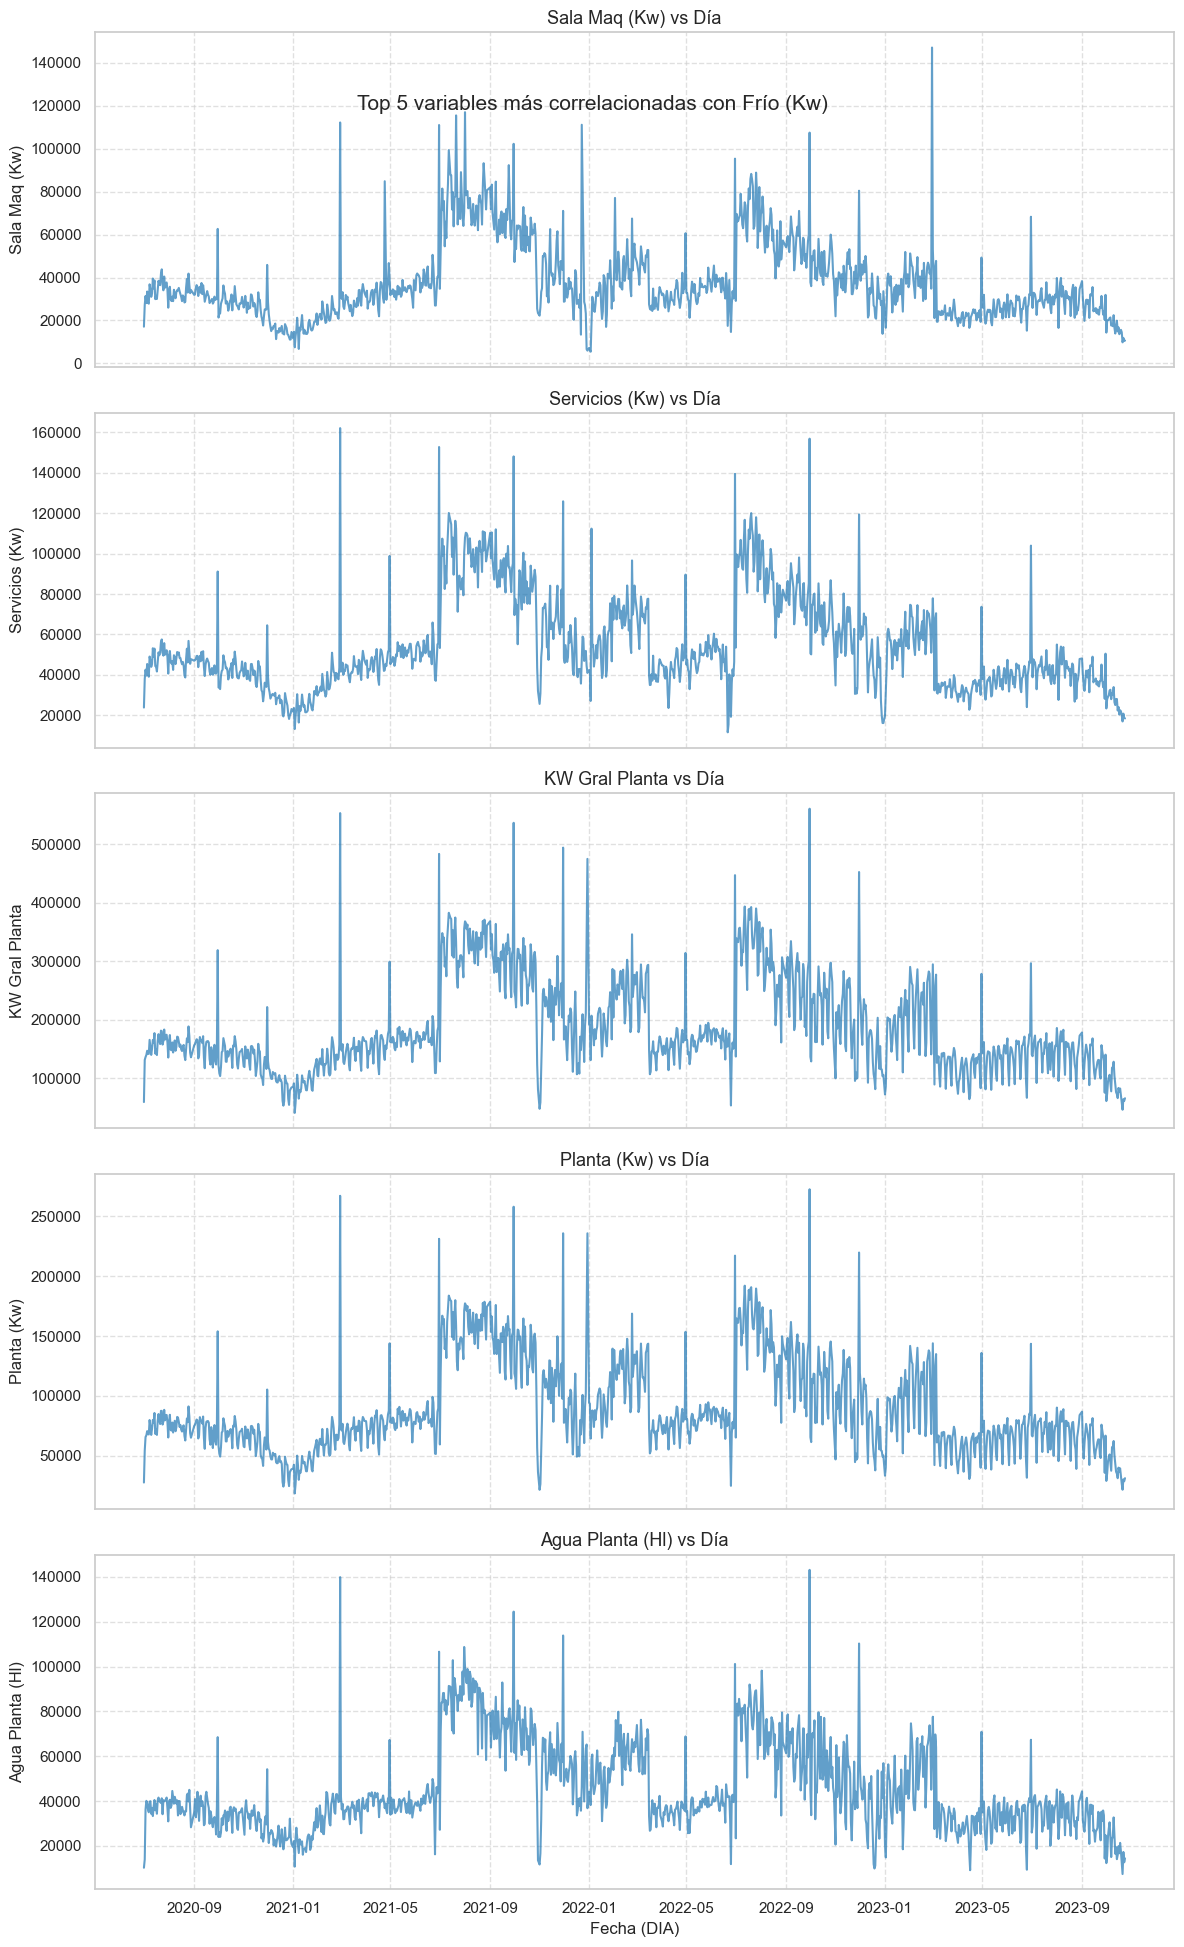

In [54]:
df_limpio["DIA"] = pd.to_datetime(df_limpio["DIA"])

# --- Tomar las 5 variables más correlacionadas ---
top5_vars = top15.head(5).index.tolist()
print("🔝 Top 5 variables seleccionadas:", top5_vars)

# --- Configuración de estilo ---
sns.set(style="whitegrid", palette="deep")

# --- Graficar scatterplots ---
fig, axes = plt.subplots(5, 1, figsize=(12, 20), sharex=True)
for i, var in enumerate(top5_vars):
    sns.lineplot(
        data=df_limpio,
        x="DIA",
        y=var,
        alpha=0.7,
        color="tab:blue",
        ax=axes[i]
    )
    axes[i].set_title(f"{var} vs Día", fontsize=13)
    axes[i].set_ylabel(var)
    axes[i].grid(True, linestyle="--", alpha=0.6)

axes[-1].set_xlabel("Fecha (DIA)")
plt.suptitle("Top 5 variables más correlacionadas con Frío (Kw)", fontsize=15, y=0.93)
plt.tight_layout()
plt.show()

Podemos ver que presentan un comportamiento muy similar a la variable Consumo de Frio en cuanto a la tendencia (por ello spearman dio un coeficiente alto.)